In [ ]:
!pip install pyquaternion
!pip install --user --upgrade pixiedust

In [1]:
from itertools import starmap
from pyquaternion import Quaternion 

from sklearn.model_selection import train_test_split
from sklearn.linear_model import MultiTaskElasticNetCV, MultiTaskElasticNet

from sklearn.metrics import mean_squared_error
from sklearn.externals import joblib

from pylab import *
import pandas as pd

np.random.seed=1
%matplotlib inline

import pixiedust

Pixiedust database opened successfully


In [2]:
def addSuffix(l, suffix):
    return [i + suffix for i in l]
    
def toEulerianAngle(q):
    ysqr = q[2] * q[2]

    t0 = +2.0 * (q[0] * q[1] + q[2] * q[3])
    t1 = +1.0 - 2.0 * (q[1] * q[1] + ysqr)
    roll = np.arctan2(t0, t1)

    t2 = +2.0 * (q[0] * q[2] - q[3] * q[1])
    t2 = 1.0 if t2 > 1.0 else t2
    t2 = -1.0 if t2 < -1.0 else t2
    pitch = np.arcsin(t2)

    t3 = +2.0 * (q[0] * q[3] + q[1] * q[2])
    t4 = +1.0 - 2.0 * (ysqr + q[3] * q[3])
    yaw = np.arctan2(t3, t4)

    return np.array([roll, pitch, yaw])


def getRollPitchYaw(q):
    return toEulerianAngle(q)


def eulerToQuaternion(roll, pitch, yaw):
    quaternion = [0] * 4
    cosPhi_2 = np.cos(roll / 2)
    sinPhi_2 = np.sin(roll / 2)
    cosTheta_2 = np.cos(pitch / 2)
    sinTheta_2 = np.sin(pitch / 2)
    cosPsi_2 = np.cos(yaw / 2)
    sinPsi_2 = np.sin(yaw / 2)

    quaternion[0] = (cosPhi_2 * cosTheta_2 * cosPsi_2 +
                     sinPhi_2 * sinTheta_2 * sinPsi_2)
    quaternion[1] = (sinPhi_2 * cosTheta_2 * cosPsi_2 -
                     cosPhi_2 * sinTheta_2 * sinPsi_2)
    quaternion[2] = (cosPhi_2 * sinTheta_2 * cosPsi_2 +
                     sinPhi_2 * cosTheta_2 * sinPsi_2)
    quaternion[3] = (cosPhi_2 * cosTheta_2 * sinPsi_2 -
                     sinPhi_2 * sinTheta_2 * cosPsi_2)

    return Quaternion(quaternion)


def transformToEarthFrame(vector, q):
    q_ = Quaternion(q)
    return q_.inverse.rotate(vector)


def transformToBodyFrame(vector, q):
    q_ = Quaternion(q)
    return q_.rotate(vector)


def generateGaussianNoise(std, mean=0):
    return np.random.normal(scale=std, loc=mean)


def wrapAroundPi(angle):
    return np.arctan2(np.sin(angle), np.cos(angle))


def integrateOrientation(euler, angularVelocity, f):
    return np.array(list(map(wrapAroundPi, euler + angularVelocity / f)))


def integratePosition(p0, v, f):
    return p0 + v / f


def getAverageAngularVelocity(p1, p0, f):
    return np.array(list(map(wrapAroundPi, p1 - p0))) * f


def getAverageLinearVelocity(p1, p0, f):
    return np.array((p1 - p0) * f)


def integrateTrajectory(initialPosition, initialOrientation, linearVelocitiesBody, angularVelocities, frequency):
    for v, w, f in zip(linearVelocitiesBody, angularVelocities, frequency):
        initialOrientation = integrateOrientation(initialOrientation, w, f)
        initialPosition = integratePosition(initialPosition,
                                            transformToEarthFrame(v, eulerToQuaternion(*initialOrientation)), f)
        yield initialPosition

In [3]:
path1 = 'C:/Users/talaa/Desktop/10hz.csv'
dataset = pd.read_csv(path1)

f = dataset['f'].values
position = ['x', 'y', 'z']
orientation = ['psi', 'theta', 'phi']
quaternion = ['scalar', 'i', 'j', 'k']

initialPositions = dataset[addSuffix(position, '0')].values
nextPositions = dataset[addSuffix(position, '1')].values
quaternions = dataset[addSuffix(quaternion, '1')].values

initialOrientations = dataset[addSuffix(orientation, '0')].values
nextOrientations = dataset[addSuffix(orientation, '1')].values

vEarth_avg = np.array(list(starmap(getAverageLinearVelocity, zip(nextPositions, initialPositions, f))))
vBody_avg = np.array(list(starmap(transformToBodyFrame, zip(vEarth_avg, quaternions))))
angularVelocities_avg = np.array(list(starmap(getAverageAngularVelocity, zip(nextOrientations, initialOrientations, f))))

for i, item in enumerate(zip(['dXB1_avg', 'dYB1_avg', 'dZB1_avg'], ['dPsi1_avg', 'dTheta1_avg', 'dPhi1_avg'])):
    v, w = item
    dataset[v] = vBody_avg[:, i]
    dataset[w] = angularVelocities_avg[:, i]
    
for i, item in enumerate(zip(['dXB0_avg', 'dYB0_avg', 'dZB0_avg'], ['dPsi0_avg', 'dTheta0_avg', 'dPhi0_avg'])):
    v, w = item
    dataset[v] = np.roll(vBody_avg[:, i], shift=1)
    dataset[w] = np.roll(angularVelocities_avg[:, i], shift=1)
    
dataset.drop(dataset.head(500).index, inplace=True)
dataset = dataset.reset_index(drop=True)

In [4]:
d = pd.get_dummies(dataset['aIndex'])
for i, item in enumerate(d.columns):
    dataset['a'+ str(i)] = d[item]

In [5]:
#modelInputs = ['dXB0_avg', 'dYB0_avg', 'dZB0_avg', 'dPsi0_avg', 'dTheta0_avg', 'dPhi0_avg'] + ['psi0', 'theta0'] +\
#              ['a0', 'a1', 'a2', 'a3']
modelInputs = ['dXB0_avg', 'dYB0_avg', 'dZB0_avg', 'dPsi0_avg', 'dTheta0_avg', 'dPhi0_avg'] + ['psi0', 'theta0'] +\
              ['aIndex']

modelOutputs = ['dXB1_avg', 'dYB1_avg', 'dZB1_avg', 'dPsi1_avg', 'dTheta1_avg', 'dPhi1_avg']

modelInputs = ['dXB0', 'dYB0', 'dZB0', 'dPsi0', 'dTheta0', 'dPhi0'] + ['psi0', 'theta0'] + ['aIndex']
modelOutputs = ['dXB1_avg', 'dYB1_avg', 'dZB1', 'dPsi1', 'dTheta1', 'dPhi1']


X, y = dataset[modelInputs], dataset[modelOutputs]
xTrain, xTest, yTrain, yTest =\
train_test_split(X, y, test_size=0.20, random_state=1)

In [6]:
X.head()

,dXB0,dYB0,dZB0,dPsi0,dTheta0,dPhi0,psi0,theta0,aIndex
0,-2.515745,-1.558407,-0.295494,-0.081245,-1.542928,0.233429,0.004212,0.040487,6
1,-2.434193,-1.637146,-0.307786,-0.012851,-0.048217,0.556935,0.000556,0.002992,6
2,-2.315574,-1.789872,-0.228504,-0.002606,-0.016749,0.771453,0.000087,-0.000001,6
3,-2.148475,-1.979661,-0.176844,-0.000158,-0.002665,0.920331,-0.000025,-0.000326,6
4,-1.945889,-2.172859,-0.141391,-0.000219,-0.002409,1.017588,-0.000051,-0.000312,6


In [7]:
y.head()

,dXB1_avg,dYB1_avg,dZB1,dPsi1,dTheta1,dPhi1
0,-2.508077,-1.686923,-0.307786,-0.012851,-0.048217,0.556935
1,-2.323330,-1.796243,-0.228504,-0.002606,-0.016749,0.771453
2,-2.198226,-2.026094,-0.176844,-0.000158,-0.002665,0.920331
3,-1.932140,-2.158211,-0.141391,-0.000219,-0.002409,1.017588
4,-1.746621,-2.414271,-0.113623,-0.000262,-0.002459,1.083461


In [9]:
cvModel = MultiTaskElasticNetCV(l1_ratio=np.linspace(0.001, 1.0), max_iter=int(10e3), random_state=10, n_jobs=-1)\
          .fit(xTrain, yTrain)
    
means, stds= pd.DataFrame(cvModel.predict(X) - y, columns=y.columns).mean().values,\
             pd.DataFrame(cvModel.predict(X) - y, columns=y.columns).std().values
    
print(means, stds)

[ -3.23807634e-04   6.25440398e-05   2.18932379e-05  -5.10697466e-04
  -1.13157961e-03   4.06489497e-04] [ 0.12927263  0.13000287  0.14011302  0.19691714  0.55269092  0.10102882]


In [63]:
print(cvModel.l1_ratio_, cvModel.alpha_)
model = MultiTaskElasticNet(l1_ratio=cvModel.l1_ratio_, alpha=cvModel.alpha_, max_iter=int(10e8), random_state=10).fit(X, y)

1.0 0.00259140577609


In [43]:
def predict(limit, dataset, f):
    #actions = X[['a0', 'a1', 'a2', 'a3']].values[:limit]
    actions = X['aIndex'].values[:limit]
    current_orientation = dataset.loc[0, addSuffix(orientation, '0')].values
    
    vBody, angularVelocity, euler = np.zeros((limit, 3)), np.zeros((limit, 3)), np.zeros((limit, 3))
    for index in range(limit):
        if index != 0:
            s0 = np.concatenate((prediction, current_orientation[:-1], [actions[index]]))
        else:
            s0 = X.iloc[0].values
        
        prediction = model.predict(s0.reshape(1, -1))[0]
        current_orientation = integrateOrientation(current_orientation, prediction[[3, 4, 5]], f)
        
        euler[index] = current_orientation
        vBody[index] = prediction[[0, 1, 2]]
        angularVelocity[index] = prediction[[3, 4, 5]]
    
    return vBody, angularVelocity, euler

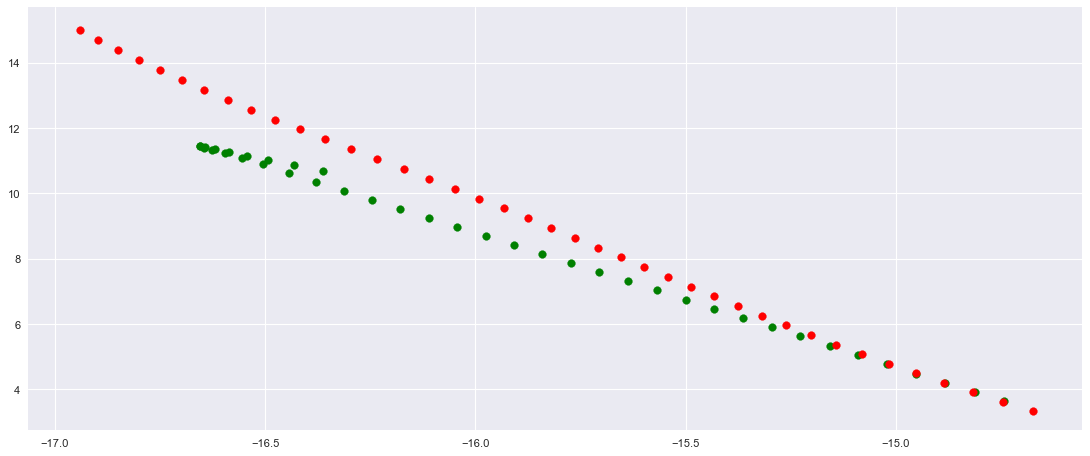

In [61]:
import warnings
warnings.filterwarnings("ignore")

limit=5000
figure(num=None, figsize=(17, 7), dpi=80, facecolor='w', edgecolor='k')
vBody, w, euler = predict(limit=limit, dataset=dataset, f=10)
gen = integrateTrajectory(dataset.loc[0, addSuffix(position , '0')].values, 
                          dataset.loc[0, addSuffix(orientation , '0')].values, vBody, w, f)

positions = np.zeros((limit, 3))
for i in range(40):
    p = next(gen)
    positions[i] = p
    plt.scatter(p[0], p[1], color='red')
    plt.scatter(dataset.loc[i, ['x1']].values, dataset.loc[i, ['y1']].values, color='green') 

In [55]:
np.sum(np.rad2deg(list(map(lambda x: wrapAroundPi(x), w[:25]-dataset[['dPsi1', 'dTheta1', 'dPhi1']].values[:25]))))/10.0

-142.78474546350441


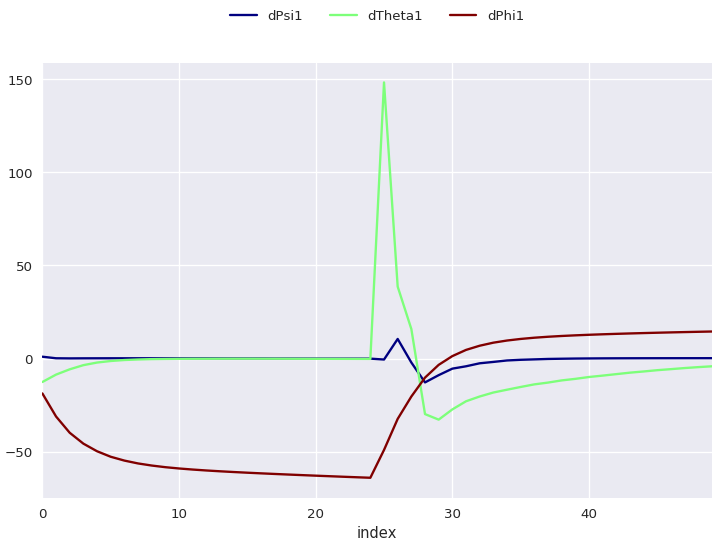

In [53]:
wError = pd.DataFrame(np.rad2deg(list(map(lambda x: wrapAroundPi(x),
                                          w-dataset[['dPsi1', 'dTheta1', 'dPhi1']].values[:limit]))),
                      columns=['dPsi1', 'dTheta1', 'dPhi1'])
wError['index'] = wError.index
display(wError[:50])


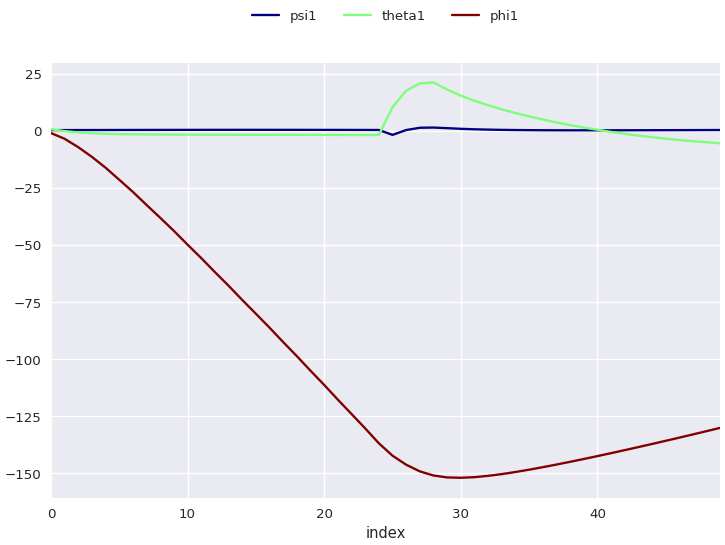

In [52]:
orientationError = pd.DataFrame(np.rad2deg(list(map(lambda x: wrapAroundPi(x),
                                                    euler-dataset[['psi1', 'theta1', 'phi1']].values[:limit]))),
                                columns=['psi1', 'theta1', 'phi1'])
orientationError['index'] = orientationError.index
display(orientationError[:50])


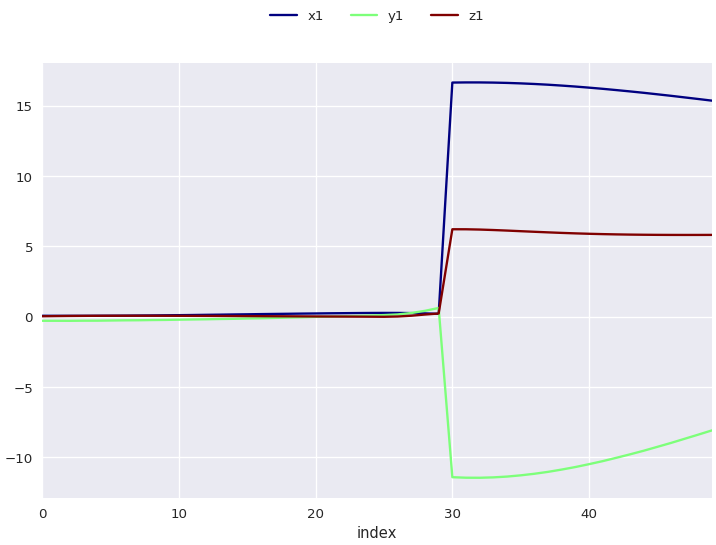

In [51]:
positionError = pd.DataFrame(positions-dataset[['x1', 'y1', 'z1']].values[:limit], columns=['x1', 'y1', 'z1'])
positionError['index'] = positionError.index
display(positionError[:50])

In [157]:
joblib.dump(model, 'C:/Users/talaa/PycharmProjects/rl/src/linearModel.model')

['C:/Users/talaa/PycharmProjects/rl/src/linearModel.model']